In [1]:
#mount the drive where we have the downloaded trained weights
#Lung segmentation from Chest X-Ray dataset
#https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%tensorflow_version 1.x
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [3]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

"""
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)|
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
"""

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

Using TensorFlow backend.


In [4]:
model = unet(input_size=(512,512,1))
"""model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])"""
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
__________

In [5]:
import shutil
src="/content/drive/My Drive/Lung_UNet_Weights/cxr_reg_weights.best.hdf5"
des="/content/unet_weights.hdf5"
shutil.copy(src,des)
#TODO replace this!

'/content/unet_weights.hdf5'

In [6]:
# Loads the weights
model.load_weights("/content/unet_weights.hdf5")

In [7]:
import shutil
src="/content/drive/My Drive/COVID_CODEIT/Filtered_Unchanged_Dataset.zip"
des="/content/DATA.zip"
shutil.copy(src,des)


'/content/DATA.zip'

In [8]:
#creates a directory without throwing an error
def create_dir(dir):
  if not os.path.exists(dir):
    os.makedirs(dir)
    print("Created Directory : ", dir)
  else:
    print("Directory already existed : ", dir)
  return dir
src="/content/DATA.zip"
des="/content/DATASET"
create_dir(des)
get_ipython().system('unzip -q {} -d {}'.format(src,des))

Created Directory :  /content/DATASET


In [9]:
"""
Rows in df: Original Image Path, Generated Boolean Mask Path, Applied Mask Path, Masking Ratio,Category : covid, Pneumonia,Normal, Opening_Failed : True False
"""
def create_dir(dir):
  if not os.path.exists(dir):
    os.makedirs(dir)
    print("Created Directory : ", dir)
  else:
    print("Directory already existed : ", dir)
  return dir

In [10]:
import pandas as pd
try:
  del df2
except:
  pass

In [11]:

df2=pd.DataFrame(columns = ['Img', 'Type','Orig_Size','Mod_Size'])

covid_path="/content/DATASET/content/final-dataset/COVID-19"
normal_path="/content/DATASET/content/final-dataset/NORMAL"
pneumonia_path="/content/DATASET/content/final-dataset/Viral Pneumonia"


from skimage import io

TYPES=["COVID","NORMAL","PNEUMONIA"]
ROOT_PATHS=[covid_path,normal_path,pneumonia_path]

for TYPE,ROOT_PATH in zip(TYPES,ROOT_PATHS):
  for each_file in os.listdir(ROOT_PATH):
    filepath=os.path.join(ROOT_PATH,each_file)

    
    
    img_data = io.imread(filepath,plugin='matplotlib', as_gray=True)
    stacked_img = np.stack((img_data,)*3, axis=-1)



    df2 = df2.append({'Img' : filepath,'Type' : TYPE, 'Orig_Size': img_data.shape , 'Mod_Size': stacked_img.shape}, 
                     ignore_index = True)


df2.to_excel("COVID_SIZES_GRAY_3MOD.xlsx",index=False)
df2.head()


Img  ...         Mod_Size
0  /content/DATASET/content/final-dataset/COVID-1...  ...  (1024, 1024, 3)
1  /content/DATASET/content/final-dataset/COVID-1...  ...  (1632, 1610, 3)
2  /content/DATASET/content/final-dataset/COVID-1...  ...    (901, 981, 3)
3  /content/DATASET/content/final-dataset/COVID-1...  ...  (2000, 2000, 3)
4  /content/DATASET/content/final-dataset/COVID-1...  ...  (1570, 1695, 3)

[5 rows x 4 columns]

In [14]:
covid_path="/content/DATASET/content/final-dataset/COVID-19"
normal_path="/content/DATASET/content/final-dataset/NORMAL"
pneumonia_path="/content/DATASET/content/final-dataset/Viral Pneumonia"


from skimage import io

TYPES=["COVID","NORMAL","PNEUMONIA"]
ROOT_PATHS=[covid_path,normal_path,pneumonia_path]

df2=pd.DataFrame(columns = ['Img', 'Type','CVOut_Size'])

for TYPE,ROOT_PATH in zip(TYPES,ROOT_PATHS):
  for each_file in os.listdir(ROOT_PATH):
    filepath=os.path.join(ROOT_PATH,each_file)

    image = cv2.imread(filepath,1)
    
    #img_data = io.imread(filepath,plugin='matplotlib', as_gray=True)
    #stacked_img = np.stack((img_data,)*3, axis=-1)



    df2 = df2.append({'Img' : filepath,'Type' : TYPE, 'CVOut_Size': image.shape }, 
                     ignore_index = True)


df2.to_excel("CVD_SIZES_OPENCV_EXPECT3MOD.xlsx",index=False)
df2.head()


Img   Type       CVOut_Size
0  /content/DATASET/content/final-dataset/COVID-1...  COVID  (1024, 1024, 3)
1  /content/DATASET/content/final-dataset/COVID-1...  COVID  (1632, 1610, 3)
2  /content/DATASET/content/final-dataset/COVID-1...  COVID    (901, 981, 3)
3  /content/DATASET/content/final-dataset/COVID-1...  COVID  (2000, 2000, 3)
4  /content/DATASET/content/final-dataset/COVID-1...  COVID  (1570, 1695, 3)

In [17]:
from skimage import io
img_path="/content/DATASET/content/final-dataset/COVID-19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2a.png"
img_data = io.imread(img_path,plugin='matplotlib', as_gray=True)
print(img_data.shape)
stacked_img = np.stack((img_data,)*3, axis=-1) #3DIM
print(stacked_img.shape)



image = cv2.imread(img_path,1)
image.shape


(576, 516)
(576, 516, 3)


(576, 516, 3)

In [ ]:
import pandas as pd
df=pd.DataFrame(columns = ['Img', 'Mask', 'Applied','Ratio','Category','Error'])

In [15]:
covid_path="/content/DATASET/content/final-dataset/COVID-19"
normal_path="/content/DATASET/content/final-dataset/NORMAL"
pneumonia_path="/content/DATASET/content/final-dataset/Viral Pneumonia"
from skimage import io

def apply_mask_mod(image,mask,bg_image=None):
    
    
    """
        This function is used to change the colorful background information to blurred image.
        image[:,:,0] is the Blue channel,image[:,:,1] is the Green channel, image[:,:,2] is the Red channel
        mask == 0 means that this pixel does not belong to the object.Rather, it belongs to the background
        np.where function means that if the pixel belong to background, change it to blur_image.
        Since the blur_image is 3D/2D, for each pixel in background, we should set 3 channels to the 
        same value to keep the blur effect.
        where there is no mask just make that part copied from blurred images

        replace image with other image(replacement_image or bg_image) where mask==0
        resets non detected parts of image with bg_image
    
    """
    s1,s2,s3=image.shape
    black_img = np.zeros([s1,s2,s3],dtype=np.uint8)
    bg_image = black_img 
    #cv2.imwrite('black_image.jpg',bg_image)
    
    #if background is not initialised , by default , consider black and white bg effect
    
    #if len(bg_image.shape)==1:
    #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #cv2.imwrite('gray_image.jpg', gray_image)
    #bg_image=gray_image

    length=len(bg_image.shape)
    
    if length==3:
        
        #copy code for apply_mask_3D(image, mask):
        image[:, :, 0] = np.where(
            mask == 0,
            bg_image[:, :, 0],
            image[:, :, 0]
        )
        image[:, :, 1] = np.where(
            mask == 0,
            bg_image[:, :, 1],
            image[:, :, 1]
        )
        image[:, :, 2] = np.where(
            mask == 0,
            bg_image[:, :, 2],
            image[:, :, 2]
        )
        return image
    else:
        #if length==2
        # copy code for apply_mask_2D(image, mask):
        image[:, :, 0] = np.where(
            mask == 0,
            bg_image[:, :],
            image[:, :, 0]
        )
        image[:, :, 1] = np.where(
            mask == 0,
            bg_image[:, :],
            image[:, :, 1]
        )
        image[:, :, 2] = np.where(
            mask == 0,
            bg_image[:, :],
            image[:, :, 2]
        )
    return image



#aim create a common function for preprocessing
def preprocess(img_path):
  dim=512
  img_data = io.imread(img_path,plugin='matplotlib', as_gray=True)
  
  stacked_img = np.stack((img_data,)*3, axis=-1) #3DIM
  img_data = np.array(stacked_img, dtype=np.uint8)
  img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2LAB)
  img_arr = cv2.resize(img_data,(dim,dim))[:,:,0]
  new_arr = img_arr.reshape(1,dim,dim,1)
  norm_arr=(new_arr-127.0)/127.0
  norm_arr=norm_arr.astype(np.float32)
  return norm_arr

def preprocessold(img_path):
  dim=512
  #img_data = io.imread(img_path,plugin='matplotlib')
  img_data = cv2.imread(img_path,1)
  img_data = np.array(img_data, dtype=np.uint8)
  img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2LAB)
  img_arr = cv2.resize(img_data,(dim,dim))[:,:,0]
  new_arr = img_arr.reshape(1,dim,dim,1)
  norm_arr=(new_arr-127.0)/127.0
  norm_arr=norm_arr.astype(np.float32)
  return norm_arr

def get_img(img_arr):
  return np.squeeze(img_arr[0])
def save_img(pred,fname):#get extension and save to fname with png #get_img passed again
  plt.imsave(fname, pred,cmap='gray',dpi=300)

In [17]:

df=pd.DataFrame(columns = ['Img', 'Mask','Applied','Category','Ratio', 'Error'])

covid_path="/content/DATASET/content/final-dataset/COVID-19"
normal_path="/content/DATASET/content/final-dataset/NORMAL"
pneumonia_path="/content/DATASET/content/final-dataset/Viral Pneumonia"


from skimage import io

TYPES=["COVID","NORMAL","PNEUMONIA"]
ROOT_PATHS=[covid_path,normal_path,pneumonia_path]

for TYPE,ROOT_PATH in zip(TYPES,ROOT_PATHS):
  for each_file in os.listdir(ROOT_PATH):
    filepath=os.path.join(ROOT_PATH,each_file)
    try:
      filename, file_extension = os.path.splitext(filepath)
      basic_fname=os.path.basename(filename)

      img=preprocessold(filepath)
      pred = model.predict(img)

      mask=get_img(pred)
      area_covered=mask.sum()/mask.size
      #print(area_covered)

      fname=str(basic_fname)+"_mask.png"
      mask_fname=os.path.join(ROOT_PATH,fname)
      #print(mask_fname)
      #save mask
      save_img(mask,mask_fname)
      
      img_data = cv2.imread(filepath)
      img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
      img_data = cv2.resize(img_data,(512,512))
      res = apply_mask_mod(img_data,mask = mask)

      fname=str(basic_fname)+"_applied.png"
      applied_fname=os.path.join(ROOT_PATH,fname)
      save_img(res,applied_fname)

      #['Img', 'Mask', 'Applied','Ratio','Category']

      df = df.append({'Img' : filepath, 'Mask' : mask_fname, 'Applied' : applied_fname, 'Ratio' : area_covered,'Category' : TYPE,
                      'Error': False },  ignore_index = True)
    except:
      print("Err")
      df = df.append({'Img' : filepath, 'Mask' : 0, 'Applied' : 0, 'Ratio' : -1,'Category' : 0,
                      'Error': True },  ignore_index = True)
      pass
    

df.to_excel("COVID_ALL.xlsx",index=False)
df.head()


Img  ...  Error
0  /content/DATASET/content/final-dataset/COVID-1...  ...  False
1  /content/DATASET/content/final-dataset/COVID-1...  ...  False
2  /content/DATASET/content/final-dataset/COVID-1...  ...  False
3  /content/DATASET/content/final-dataset/COVID-1...  ...  False
4  /content/DATASET/content/final-dataset/COVID-1...  ...  False

[5 rows x 6 columns]

In [18]:
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size
dir="/content/DATASET"
bytesize=get_size(dir)
print(bytesize, 'bytes')
print(bytesize/(1024*1024), 'megabytes')
print(bytesize/(1024*1024*1024), 'gegabytes')

1639630230 bytes
1563.6732387542725 megabytes
1.5270246472209692 gegabytes


In [19]:
import os
import zipfile
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))
def zipper(dir_path,zip_path):
    zipf = zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED)
    zipdir(dir_path, zipf)
    zipf.close()


zipper('/content/DATASET',"Zipped_Data_Orig_Mask_Applied.zip")

In [20]:
src= "/content/Zipped_Data_Orig_Mask_Applied.zip"
des="/content/drive/My Drive/COVID_CODEIT/Zipped_Data_Orig_Mask_Applied.zip"

import shutil
shutil.copy(src,des)

'/content/drive/My Drive/COVID_CODEIT/Zipped_Data_Orig_Mask_Applied.zip'

In [16]:
#apply to single image



img=preprocessold("/content/DATASET/content/final-dataset/COVID-19/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg")
pred = model.predict(img)

mask=get_img(pred)
area_covered=mask.sum()/mask.size
print(area_covered)


0.13289083540439606


([], <a list of 0 Text major ticklabel objects>)

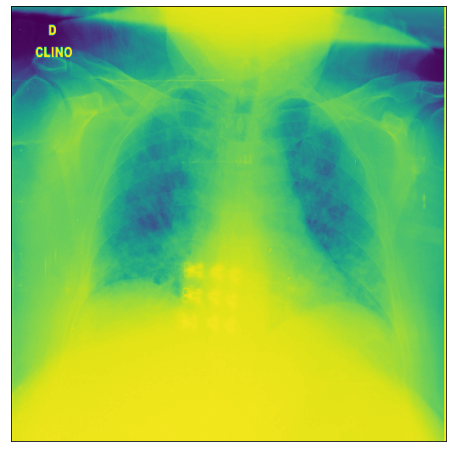

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(get_img(img))
plt.xticks([])
plt.yticks([])

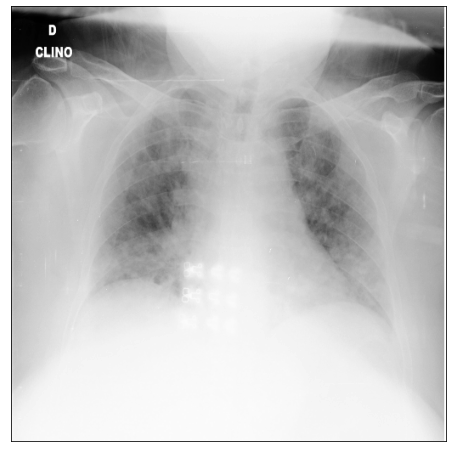

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(np.squeeze(img)
           ,cmap='gray')
plt.xticks([])
plt.yticks([]);

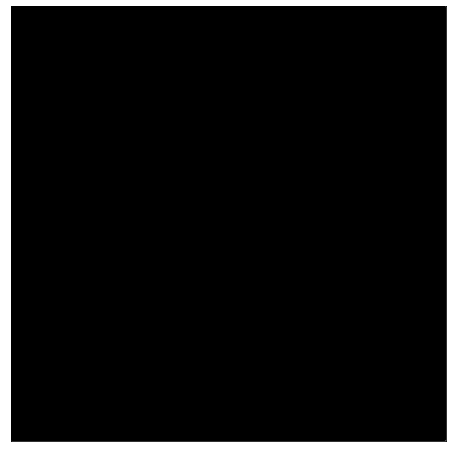

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(get_img(pred),cmap='gray')
plt.xticks([])
plt.yticks([]);

In [ ]:


TYPE="COVID"
ROOT_PATH=covid_path

for each_file in os.listdir(ROOT_PATH):
  filepath=os.path.join(ROOT_PATH,each_file)

  if(1==1):
    filename, file_extension = os.path.splitext(filepath)
    basic_fname=os.path.basename(filename)

    img=preprocess(filepath)
    pred = model.predict(img)

    mask=get_img(pred)
    area_covered=mask.sum()/mask.size
    #print(area_covered)

    fname=str(basic_fname)+"_mask.png"
    mask_fname=os.path.join(ROOT_PATH,fname)
    #print(mask_fname)
    #save mask
    save_img(mask,mask_fname)
    
    img_data = cv2.imread(filepath)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    img_data = cv2.resize(img_data,(512,512))
    res = apply_mask_mod(img_data,mask = mask)

    fname=str(basic_fname)+"_applied.png"
    applied_fname=os.path.join(ROOT_PATH,fname)
    save_img(res,applied_fname)

    #['Img', 'Mask', 'Applied','Ratio','Category']

    df = df.append({'Img' : filepath, 'Mask' : mask_fname, 'Applied' : applied_fname, 'Ratio' : area_covered,'Category' : TYPE,
                    'Error': False },  ignore_index = True)
  else:
    df = df.append({'Img' : filepath, 'Mask' : False, 'Applied' : False, 'Ratio' : False,'Category' : TYPE,
                    'Error': True },  ignore_index = True)



error: ignored

In [ ]:
df.head()

Img   Mask  ... Category Error
0  /content/DATASET/content/final-dataset/COVID-1...  False  ...    COVID  True
1  /content/DATASET/content/final-dataset/COVID-1...  False  ...    COVID  True
2  /content/DATASET/content/final-dataset/COVID-1...  False  ...    COVID  True
3  /content/DATASET/content/final-dataset/COVID-1...  False  ...    COVID  True
4  /content/DATASET/content/final-dataset/COVID-1...  False  ...    COVID  True

[5 rows x 6 columns]

In [ ]:
covid_path="/content/DATASET/content/final-dataset/COVID-19"
normal_path="/content/DATASET/content/final-dataset/NORMAL"
pneumonia_path="/content/DATASET/content/final-dataset/Viral Pneumonia"

TYPE="NORMAL"
ROOT_PATH=normal_path


for each_file in os.listdir(ROOT_PATH):
  filepath=os.path.join(ROOT_PATH,each_file)

  try:
    filename, file_extension = os.path.splitext(filepath)
    basic_fname=os.path.basename(filename)

    img=preprocess(img_path)
    pred = model.predict(img)

    mask=get_img(pred)
    area_covered=mask.sum()/mask.size
    #print(area_covered)

    fname=str(basic_fname)+"_mask.png"
    mask_fname=os.path.join(ROOT_PATH,fname)
    #save mask
    save_img(mask,mask_fname)
    
    img_data = cv2.imread(img_path)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    img_data = cv2.resize(img_data,(512,512))
    res = apply_mask_mod(img_data,mask = mask)

    fname=str(basic_fname)+"_applied.png"
    applied_fname=os.path.join(ROOT_PATH,fname)
    save_img(res,applied_fname)

    #['Img', 'Mask', 'Applied','Ratio','Category']

    df = df.append({'Img' : filepath, 'Mask' : mask_fname, 'Applied' : applied_fname, 'Ratio' : area_covered,'Category' : TYPE,
                    'Error': False },  ignore_index = True)
  except:
    df = df.append({'Img' : filepath, 'Mask' : False, 'Applied' : False, 'Ratio' : False,'Category' : TYPE,
                    'Error': True },  ignore_index = True)


In [ ]:
filepath = "/content/covid_im.png" # A Windows style file path.
os.path.basename(filepath)

'covid_im.png'

In [ ]:
filename, file_extension = os.path.splitext(filepath)

os.path.basename(filename)

'covid_im'

In [ ]:
img_path="/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/1-s2.0-S0140673620303706-fx1_lrg.jpg"
img_data = cv2.imread(img_path)
img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
img_data = cv2.resize(img_data,(512,512))
print(img_data.shape)

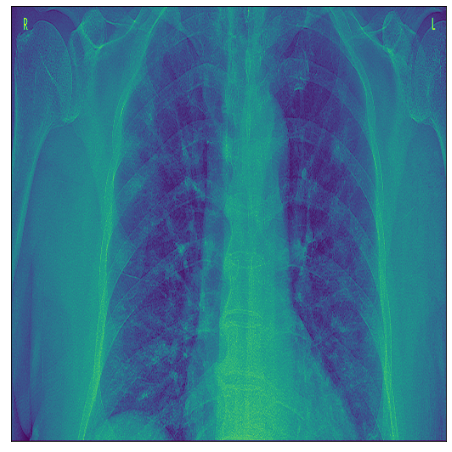

In [ ]:
#aim create a common function for preprocessing
from skimage import io

def preprocess(img_path):
  dim=512
  img_data = cv2.imread(img_path)
  img_arr = cv2.resize(img_data,(dim,dim))[:,:,0]
  new_arr = img_arr.reshape(1,dim,dim,1)
  norm_arr=(new_arr-127.0)/127.0
  norm_arr=norm_arr.astype(np.float32)
  return norm_arr
img_path="/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/1-s2.0-S0140673620303706-fx1_lrg.jpg"
img=preprocess(img_path)
pred = model.predict(img)

def get_img(img_arr):
  return np.squeeze(img_arr[0])

plt.figure(figsize=(8,8))
plt.imshow(get_img(img))
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)

(512, 512, 3)


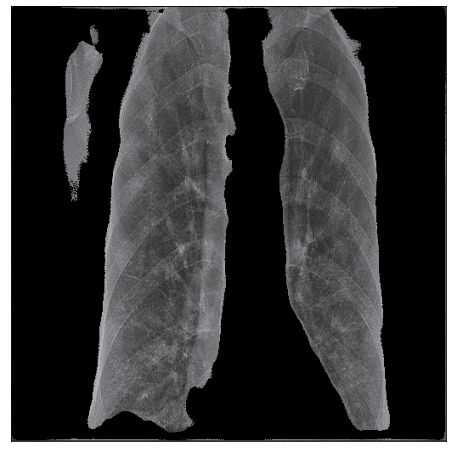

In [ ]:
img_path="/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/1-s2.0-S0140673620303706-fx1_lrg.jpg"
img_data = cv2.imread(img_path)
img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
img_data = cv2.resize(img_data,(512,512))
print(img_data.shape)

def apply_mask_mod(image,mask,bg_image=None):
    
    
    """
        This function is used to change the colorful background information to blurred image.
        image[:,:,0] is the Blue channel,image[:,:,1] is the Green channel, image[:,:,2] is the Red channel
        mask == 0 means that this pixel does not belong to the object.Rather, it belongs to the background
        np.where function means that if the pixel belong to background, change it to blur_image.
        Since the blur_image is 3D/2D, for each pixel in background, we should set 3 channels to the 
        same value to keep the blur effect.
        where there is no mask just make that part copied from blurred images

        replace image with other image(replacement_image or bg_image) where mask==0
        resets non detected parts of image with bg_image
    
    """
    s1,s2,s3=image.shape
    black_img = np.zeros([s1,s2,s3],dtype=np.uint8)
    bg_image = black_img 
    #cv2.imwrite('black_image.jpg',bg_image)
    
    #if background is not initialised , by default , consider black and white bg effect
    
    #if len(bg_image.shape)==1:
    #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #cv2.imwrite('gray_image.jpg', gray_image)
    #bg_image=gray_image

    length=len(bg_image.shape)
    
    if length==3:
        
        #copy code for apply_mask_3D(image, mask):
        image[:, :, 0] = np.where(
            mask == 0,
            bg_image[:, :, 0],
            image[:, :, 0]
        )
        image[:, :, 1] = np.where(
            mask == 0,
            bg_image[:, :, 1],
            image[:, :, 1]
        )
        image[:, :, 2] = np.where(
            mask == 0,
            bg_image[:, :, 2],
            image[:, :, 2]
        )
        return image
    else:
        #if length==2
        # copy code for apply_mask_2D(image, mask):
        image[:, :, 0] = np.where(
            mask == 0,
            bg_image[:, :],
            image[:, :, 0]
        )
        image[:, :, 1] = np.where(
            mask == 0,
            bg_image[:, :],
            image[:, :, 1]
        )
        image[:, :, 2] = np.where(
            mask == 0,
            bg_image[:, :],
            image[:, :, 2]
        )
    return image


img=preprocess(img_path)
pred = model.predict(img)
mask=get_img(pred)

res = apply_mask_mod(img_data,mask = mask)

plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(res,cmap='gray')
plt.savefig("/content/applied_mask.png",dpi=96)
plt.imsave("appliedmask.png", res,cmap='gray',dpi=300)

(512, 512)

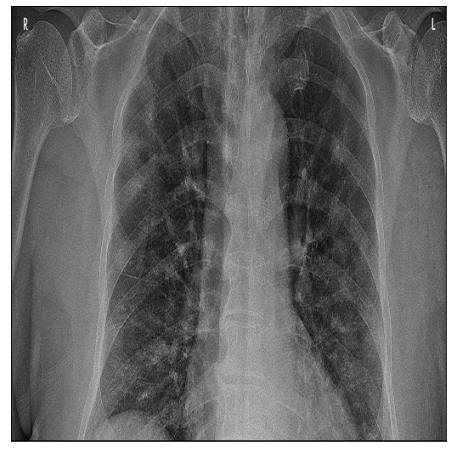

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(get_img(img),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)
get_img(img).shape

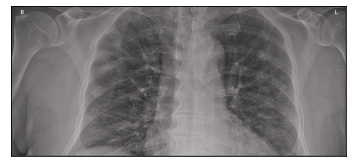

In [ ]:
#plt.figure(figsize=(8,8))
img_data = cv2.imread(img_path)
#print(img_data.shape)
plt.imshow(img_data,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)

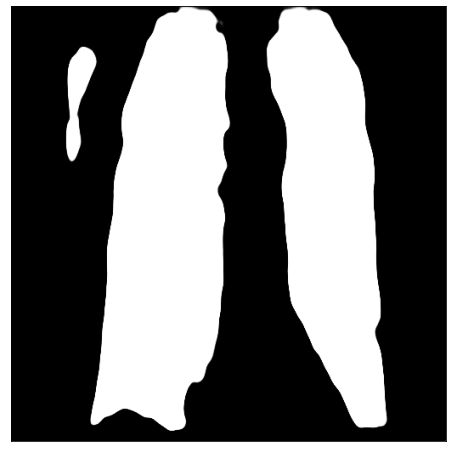

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(get_img(pred),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=300)

In [ ]:
get_img(pred).shape

(512, 512)

In [ ]:
get_img(pred)

array([[1.34878457e-02, 4.06831503e-04, 4.78625298e-05, ...,
        1.87516212e-04, 3.18303704e-03, 4.38552201e-02],
       [9.39875841e-04, 2.71201134e-06, 2.98023224e-08, ...,
        5.36441803e-07, 4.70876694e-05, 4.19235229e-03],
       [6.34193420e-05, 2.98023224e-08, 0.00000000e+00, ...,
        0.00000000e+00, 1.16229057e-06, 4.97072935e-04],
       ...,
       [9.97543335e-04, 5.00679016e-06, 5.96046448e-08, ...,
        6.85453415e-07, 3.91304493e-05, 3.44362855e-03],
       [5.22270799e-03, 1.16854906e-04, 3.01003456e-06, ...,
        3.17692757e-05, 3.89575958e-04, 1.71582997e-02],
       [5.28962314e-02, 7.45138526e-03, 7.63505697e-04, ...,
        2.80663371e-03, 1.28542483e-02, 7.66941607e-02]], dtype=float32)

In [ ]:
get_img(pred).max()

1.0

In [ ]:
pred.shape

(1, 512, 512, 1)

In [ ]:
from PIL import Image

img = Image.fromarray(get_img(pred),mode='1')
img.show()
img.save("sample9.jpg")

In [ ]:
cv2.imwrite('test_image.png', get_img(pred))

True

In [ ]:
# suppose that img's dtype is 'float64'
img_uint8 =  get_img(pred).astype(np.uint8)

io.imsave('test_image.png',img_uint8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: test_image.png is a low contrast image
  after removing the cwd from sys.path.


In [ ]:
#np.where(pred < 0.01, 0, pred)

/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/6b44464d-73a7-4cf3-bbb6-ffe7168300e3.annot.original.jpeg
Normal loading failed


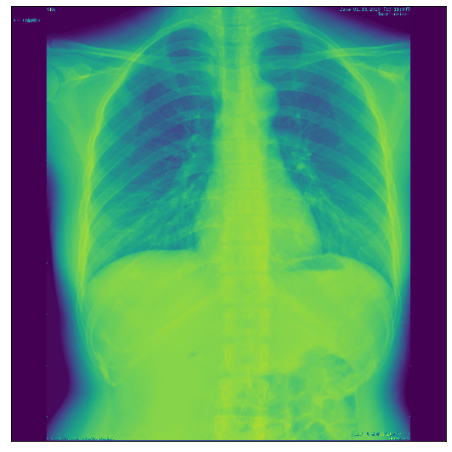

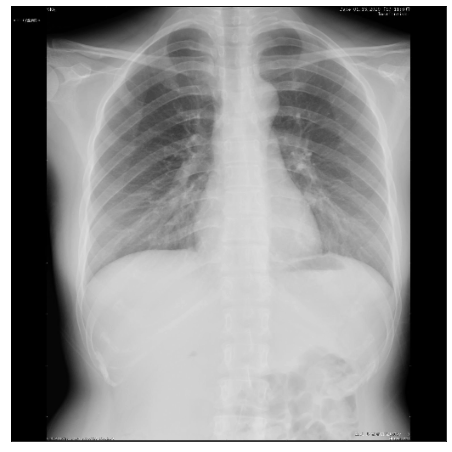

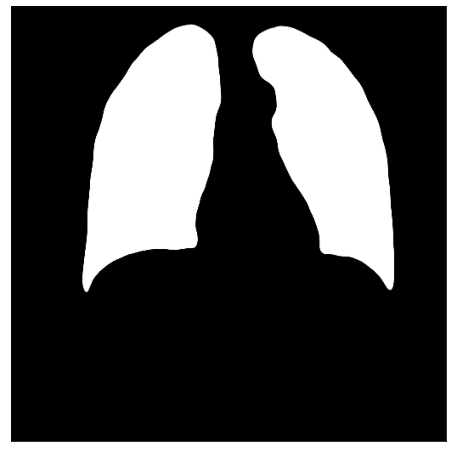

In [ ]:
direc="/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/"
main_path=os.listdir(direc)
img_path=os.path.join(direc,main_path[0])
print(img_path)

from skimage import io
"""
from skimage import io

img = io.imread(file_path)
"""

def preprocess(img_path):
  dim=512
  try:
    img_data = cv2.imread(img_path)
    if img_data==None:
      raise Err
  except:
    print("Normal loading failed")
    img_data = io.imread(img_path)
  img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2LAB)
  img_arr = cv2.resize(img_data,(dim,dim))[:,:,0]
  new_arr = img_arr.reshape(1,dim,dim,1)
  norm_arr=(new_arr-127.0)/127.0
  norm_arr=norm_arr.astype(np.float32)
  return norm_arr

img=preprocess(img_path)
pred = model.predict(img)

plt.figure(figsize=(8,8))
plt.imshow(get_img(img))
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)


plt.figure(figsize=(8,8))
plt.imshow(get_img(img),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)


plt.figure(figsize=(8,8))
plt.imshow(get_img(pred),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)

/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19 (94).png
Normal loading failed


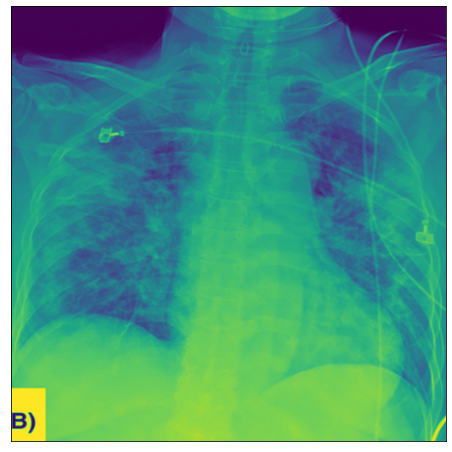

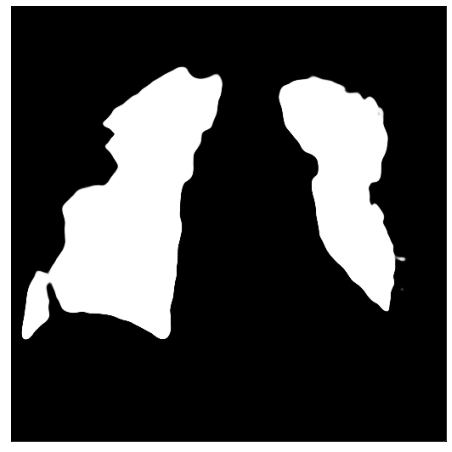

In [ ]:
direc="/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/"
main_path=os.listdir(direc)
img_path=os.path.join(direc,main_path[1])
print(img_path)

from skimage import io
"""
from skimage import io

img = io.imread(file_path)
"""

def preprocess(img_path):
  dim=512
  try:
    img_data = cv2.imread(img_path)
    if img_data==None:
      raise Err
  except:
    print("Normal loading failed")
    img_data = io.imread(img_path)
  img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2LAB)
  img_arr = cv2.resize(img_data,(dim,dim))[:,:,0]
  new_arr = img_arr.reshape(1,dim,dim,1)
  norm_arr=(new_arr-127.0)/127.0
  norm_arr=norm_arr.astype(np.float32)
  return norm_arr

img=preprocess(img_path)
pred = model.predict(img)

plt.figure(figsize=(8,8))
plt.imshow(get_img(img))
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)

"""
plt.figure(figsize=(8,8))
plt.imshow(get_img(img),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)
"""


plt.figure(figsize=(8,8))
plt.imshow(get_img(pred),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)
#/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/6b44464d-73a7-4cf3-bbb6-ffe7168300e3.annot.original.jpeg
#/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19 (94).png medical noise

/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19(209).png
Normal loading failed


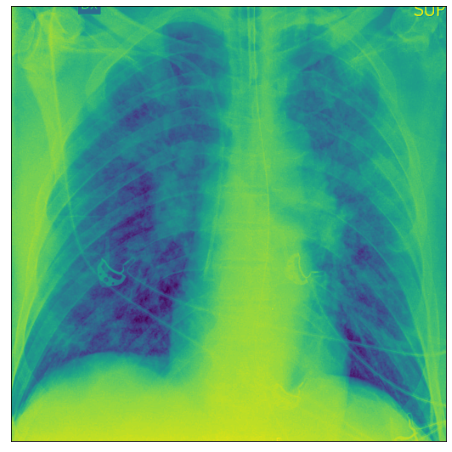

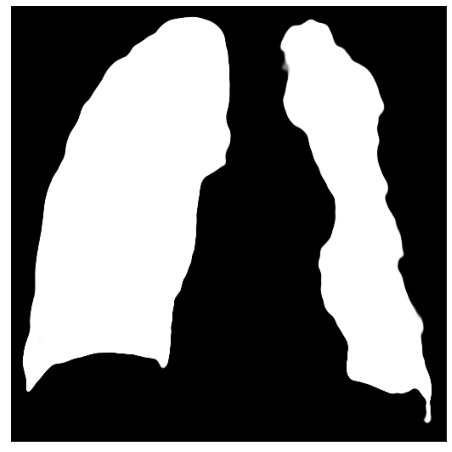

In [ ]:
direc="/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/"
main_path=os.listdir(direc)
img_path=os.path.join(direc,main_path[2])
print(img_path)

from skimage import io
"""
from skimage import io

img = io.imread(file_path)
"""

def preprocess(img_path):
  dim=512
  try:
    img_data = cv2.imread(img_path)
    if img_data==None:
      raise Err
  except:
    print("Normal loading failed")
    img_data = io.imread(img_path)
  img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2LAB)
  img_arr = cv2.resize(img_data,(dim,dim))[:,:,0]
  new_arr = img_arr.reshape(1,dim,dim,1)
  norm_arr=(new_arr-127.0)/127.0
  norm_arr=norm_arr.astype(np.float32)
  return norm_arr

img=preprocess(img_path)
pred = model.predict(img)

plt.figure(figsize=(8,8))
plt.imshow(get_img(img))
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)

"""
plt.figure(figsize=(8,8))
plt.imshow(get_img(img),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)
"""


plt.figure(figsize=(8,8))
plt.imshow(get_img(pred),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)
#/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/6b44464d-73a7-4cf3-bbb6-ffe7168300e3.annot.original.jpeg
#/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19 (94).png medical noise

/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19(199).png
Normal loading failed


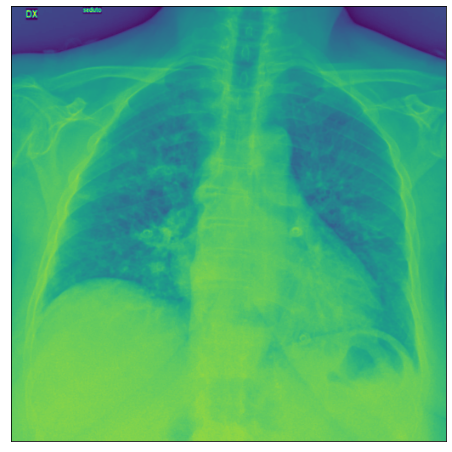

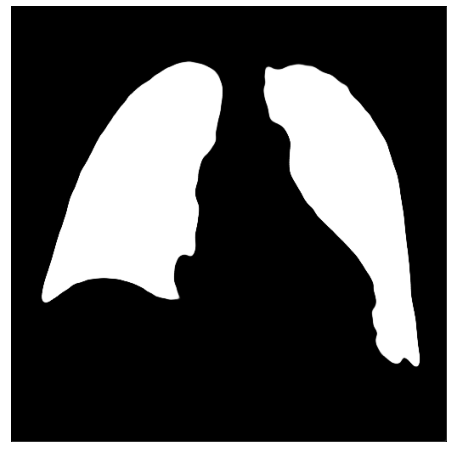

In [ ]:
direc="/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/"
main_path=os.listdir(direc)
img_path=os.path.join(direc,main_path[3])
print(img_path)

from skimage import io
"""
from skimage import io

img = io.imread(file_path)
"""

def preprocess(img_path):
  dim=512
  try:
    img_data = cv2.imread(img_path)
    if img_data==None:
      raise Err
  except:
    print("Normal loading failed")
    img_data = io.imread(img_path)
  img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2LAB)
  img_arr = cv2.resize(img_data,(dim,dim))[:,:,0]
  new_arr = img_arr.reshape(1,dim,dim,1)
  norm_arr=(new_arr-127.0)/127.0
  norm_arr=norm_arr.astype(np.float32)
  return norm_arr

img=preprocess(img_path)
pred = model.predict(img)

plt.figure(figsize=(8,8))
plt.imshow(get_img(img))
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)

"""
plt.figure(figsize=(8,8))
plt.imshow(get_img(img),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)
"""


plt.figure(figsize=(8,8))
plt.imshow(get_img(pred),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)
#/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/6b44464d-73a7-4cf3-bbb6-ffe7168300e3.annot.original.jpeg
#/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19 (94).png medical noise

In [ ]:
mask=get_img(pred)
area_covered=mask.sum()/mask.size
print(area_covered)

0.24655382335186005


/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19 (132).png
Normal loading failed


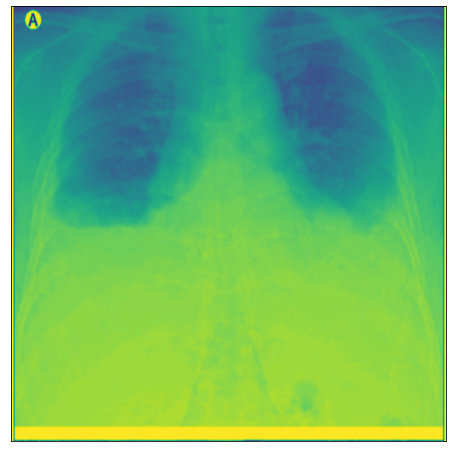

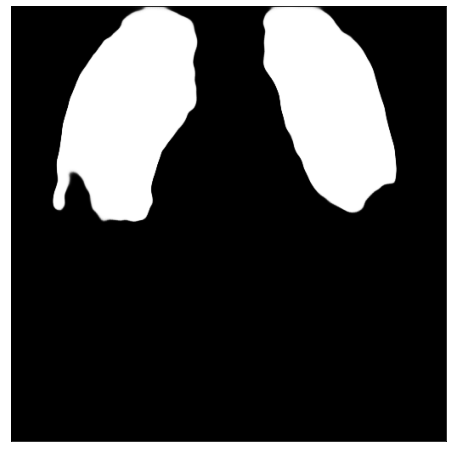

In [ ]:
direc="/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/"
main_path=os.listdir(direc)
img_path=os.path.join(direc,main_path[4])
print(img_path)

from skimage import io
"""
from skimage import io

img = io.imread(file_path)
"""

def preprocess(img_path):
  dim=512
  try:
    img_data = cv2.imread(img_path)
    if img_data==None:
      raise Err
  except:
    print("Normal loading failed")
    img_data = io.imread(img_path)
  img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2LAB)
  img_arr = cv2.resize(img_data,(dim,dim))[:,:,0]
  new_arr = img_arr.reshape(1,dim,dim,1)
  norm_arr=(new_arr-127.0)/127.0
  norm_arr=norm_arr.astype(np.float32)
  return norm_arr

img=preprocess(img_path)
pred = model.predict(img)

plt.figure(figsize=(8,8))
plt.imshow(get_img(img))
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)

"""
plt.figure(figsize=(8,8))
plt.imshow(get_img(img),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)
"""


plt.figure(figsize=(8,8))
plt.imshow(get_img(pred),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)
#/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/6b44464d-73a7-4cf3-bbb6-ffe7168300e3.annot.original.jpeg
#/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19 (94).png medical noise

In [ ]:
mask=get_img(pred)
area_covered=mask.sum()/mask.size
print(area_covered)

0.20206306874752045


Normal loading failed
Normal loading failed
Normal loading failed
Normal loading failed
Normal loading failed
Normal loading failed
/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19 (57).png
0.1792195439338684
Normal loading failed
/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19 (122).png
0.1771022081375122
Normal loading failed
/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19 (8).png
0.17139782011508942
Normal loading failed
Normal loading failed
/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19 (3).png
0.19145557284355164
Normal loading failed
/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg
0.19527234137058258
Normal loading failed
Normal loading failed
Normal loading failed
Normal loading failed
Normal loading failed
Normal loading failed
/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19 (104).png
0.12756305932998657
Normal loading failed


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Normal loading failed
Normal loading failed
/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19(144).png
0.1919923722743988
Normal loading failed
/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19 (118).png
0.18097448348999023
Normal loading failed
Normal loading failed
Normal loading failed
Normal loading failed
Normal loading failed
Normal loading failed


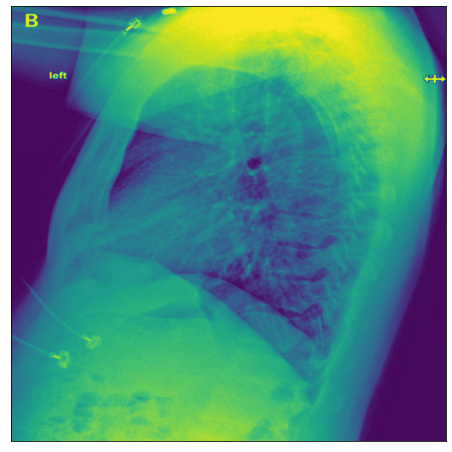

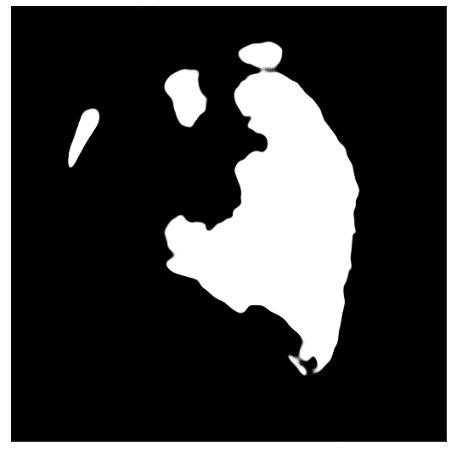

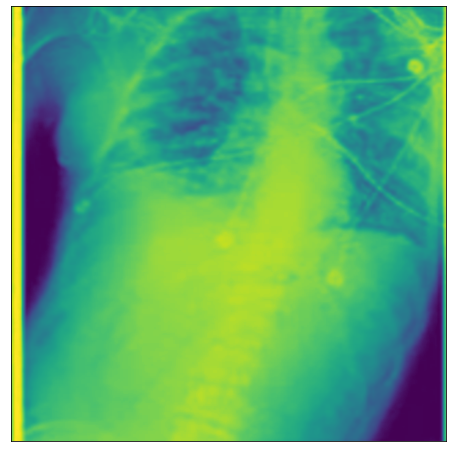

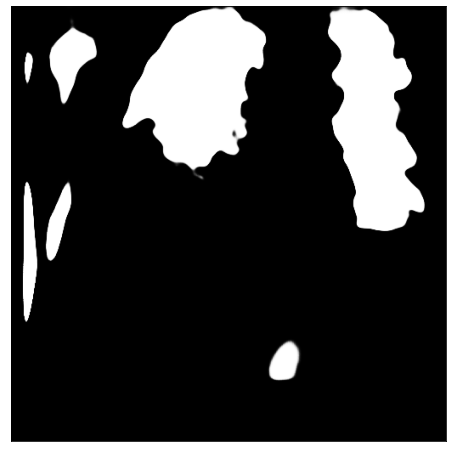

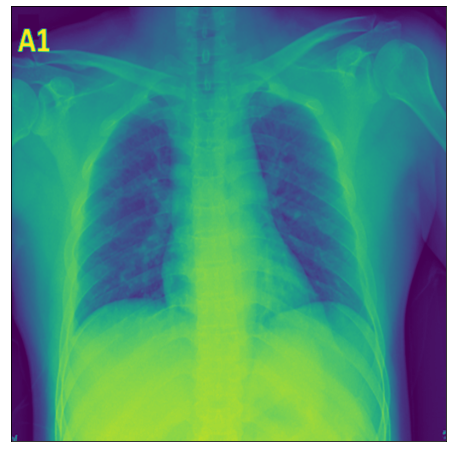

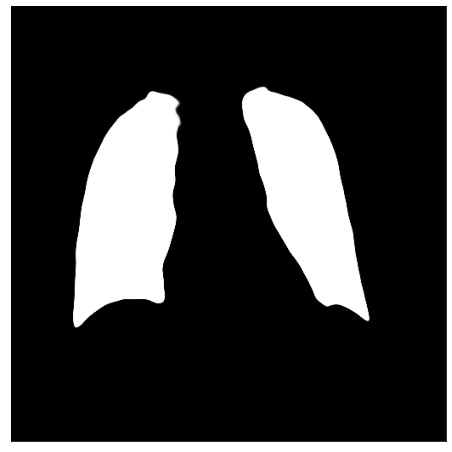

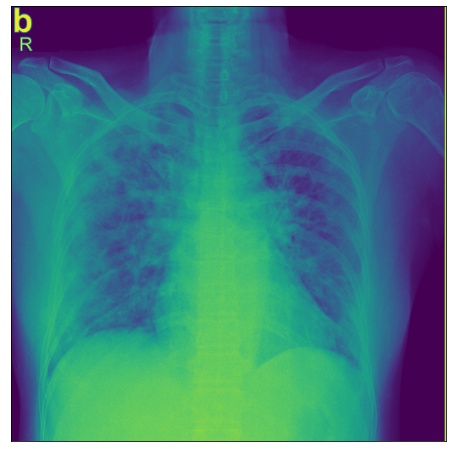

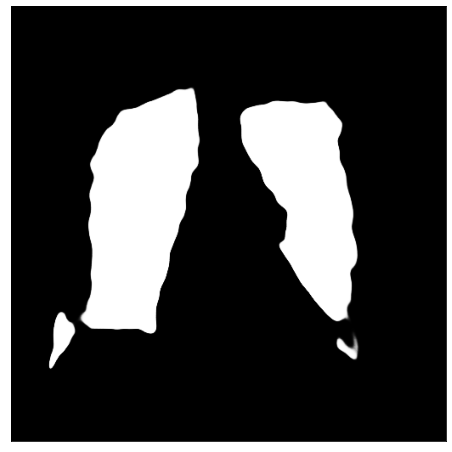

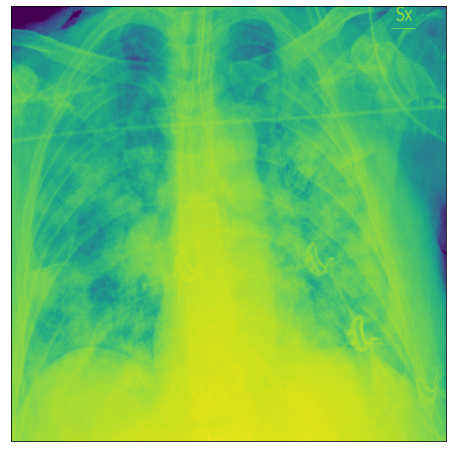

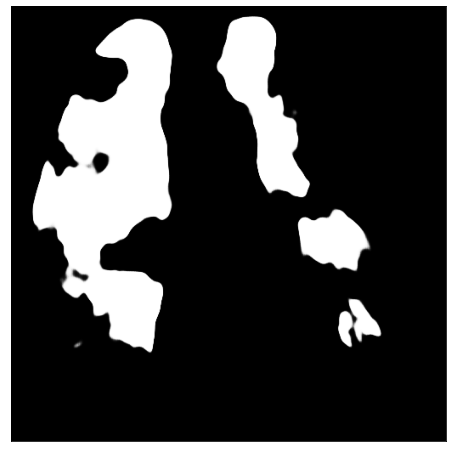

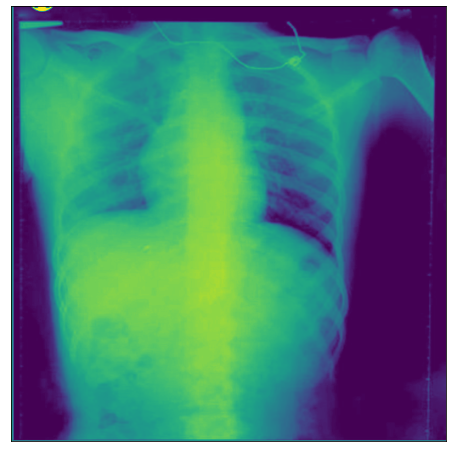

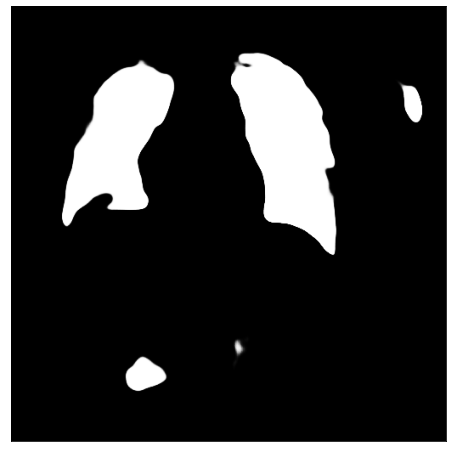

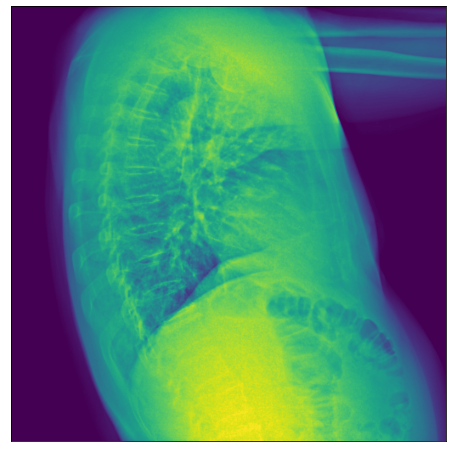

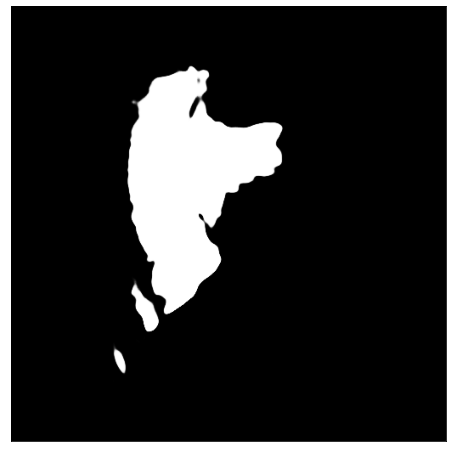

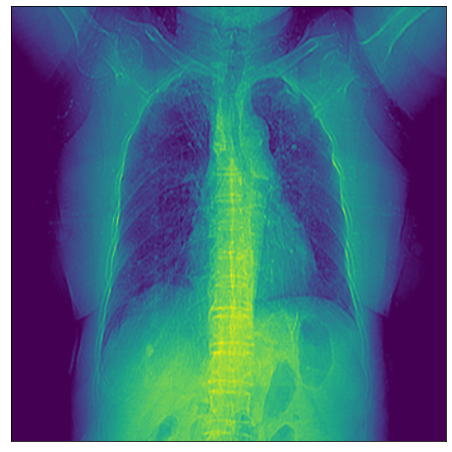

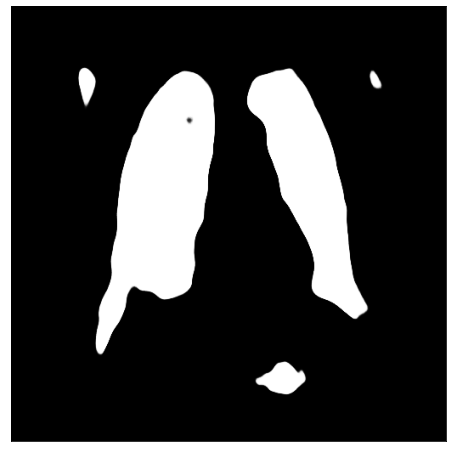

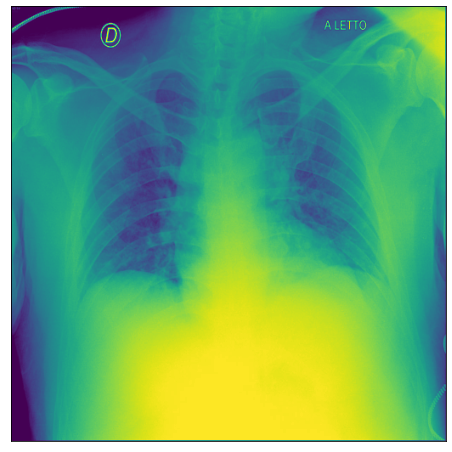

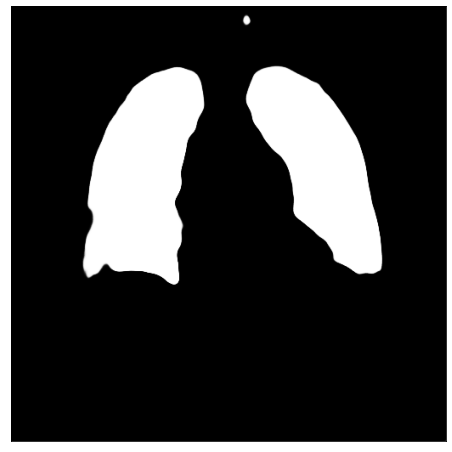

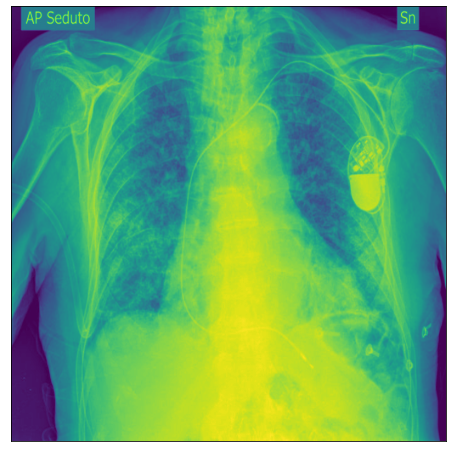

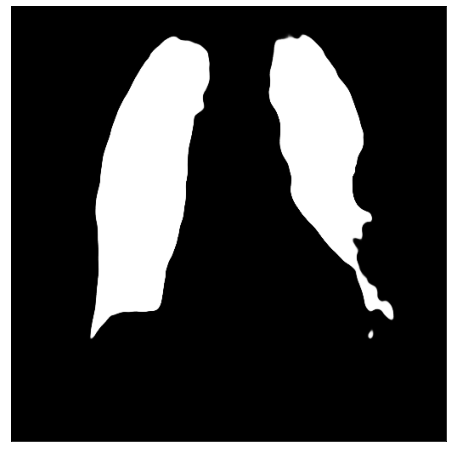

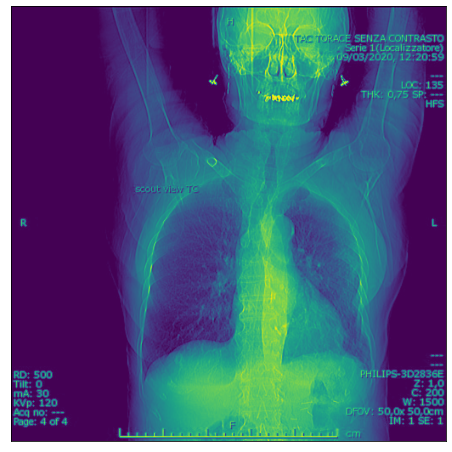

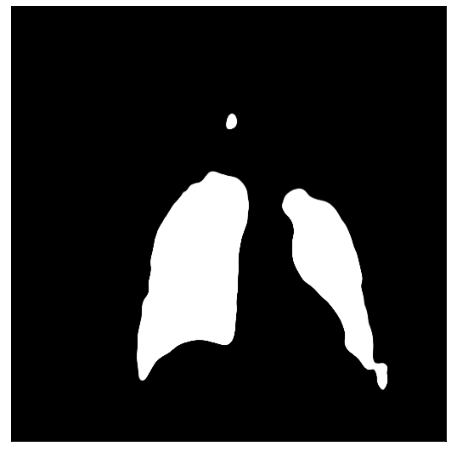

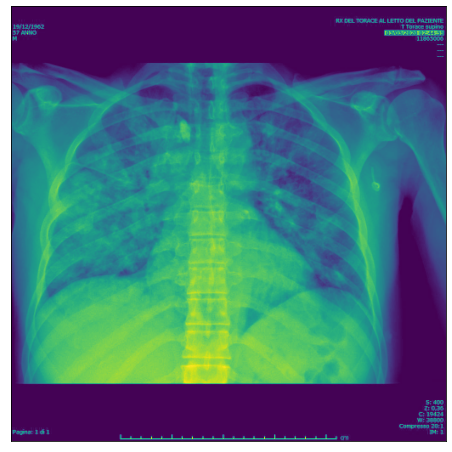

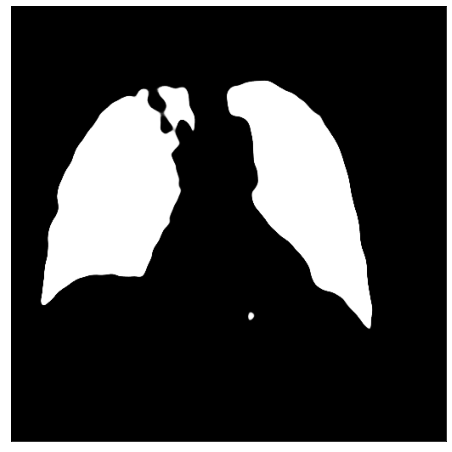

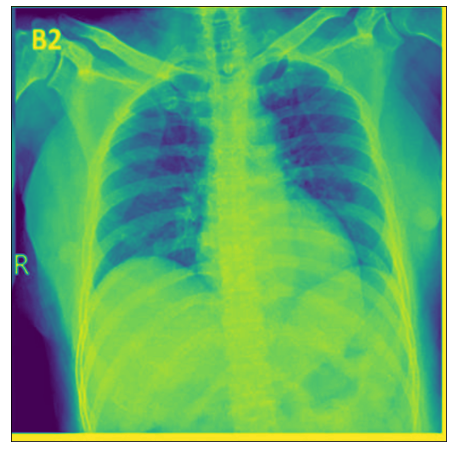

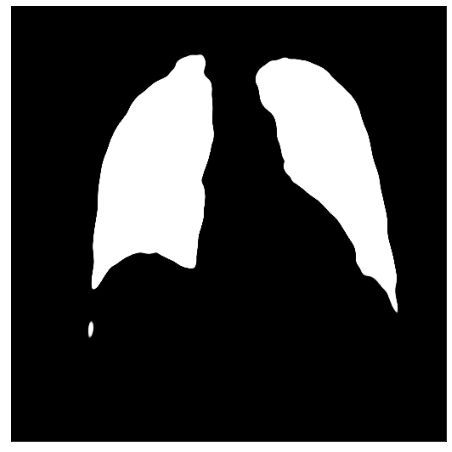

In [ ]:
direc="/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/"
main_path=os.listdir(direc)
#img_path=os.path.join(direc,main_path[4])
from skimage import io

def preprocess(img_path):
    dim=512
    try:
      img_data = cv2.imread(img_path)
      if img_data==None:
        raise "ERR"
    except:
      print("Normal loading failed")
      img_data = io.imread(img_path)
    #img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2LAB)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    img_arr = cv2.resize(img_data,(dim,dim))[:,:,0]
    new_arr = img_arr.reshape(1,dim,dim,1)
    norm_arr=(new_arr-127.0)/127.0
    norm_arr=norm_arr.astype(np.float32)
    return norm_arr

for img_path in main_path[:50]:
  img_path=os.path.join(direc,img_path)
  img=preprocess(img_path)
  pred = model.predict(img)
  mask=get_img(pred)
  area_covered=mask.sum()/mask.size
  if area_covered<0.2:
    print(img_path)
    print(area_covered)


    
    plt.figure(figsize=(8,8))
    plt.imshow(get_img(img))
    plt.xticks([])
    plt.yticks([])
    plt.savefig("/content/covid_im.png",dpi=96)

    """
    plt.figure(figsize=(8,8))
    plt.imshow(get_img(img),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.savefig("/content/covid_im.png",dpi=96)
    """


    plt.figure(figsize=(8,8))
    plt.imshow(get_img(pred),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.savefig("/content/covid_im.png",dpi=96)
    #/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/6b44464d-73a7-4cf3-bbb6-ffe7168300e3.annot.original.jpeg
    #/content/drive/My Drive/NEW_DATA/DATA_TRIMMED/Val/COVID-19/COVID-19 (94).png medical noise

(512, 512, 3)


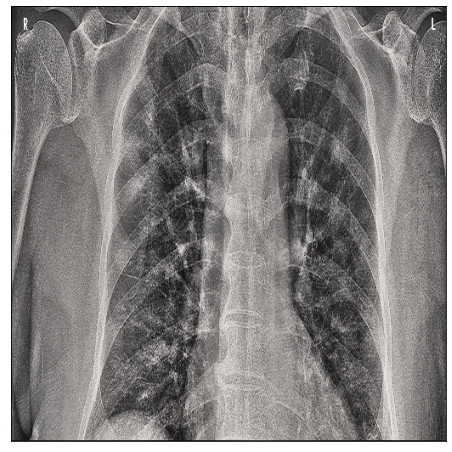

In [ ]:
#clahe

def applyCLAHE(image_path):
  dim=512
  bgr = cv2.imread(image_path)
  bgr = cv2.resize(bgr, (dim, dim)) 
  lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)

  lab_planes = cv2.split(lab)
  gridsize=8
  clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

  lab_planes[0] = clahe.apply(lab_planes[0])

  lab = cv2.merge(lab_planes)

  bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  return bgr
"""
from google.colab.patches import cv2_imshow
cv2_imshow(bgr)"""
plt.figure(figsize=(8,8))
plt.imshow(applyCLAHE(img_path),cmap='gray')

plt.xticks([])
plt.yticks([])
plt.savefig("/content/covid_im.png",dpi=96)
print(applyCLAHE(img_path).shape)

(512, 512)
(512, 3)
(512, 512)


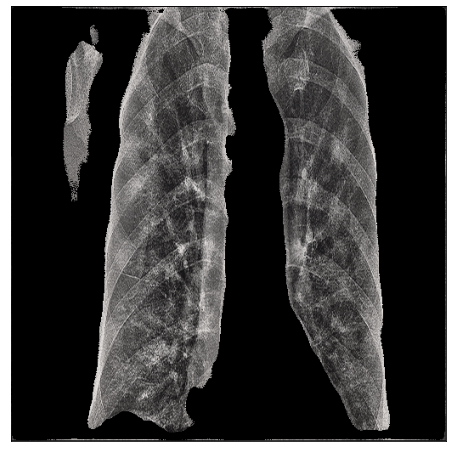

In [ ]:
#applying the mask

def apply_mask_mod(image,mask,bg_image=None):
    
    
    """
        This function is used to change the colorful background information to blurred image.
        image[:,:,0] is the Blue channel,image[:,:,1] is the Green channel, image[:,:,2] is the Red channel
        mask == 0 means that this pixel does not belong to the object.Rather, it belongs to the background
        np.where function means that if the pixel belong to background, change it to blur_image.
        Since the blur_image is 3D/2D, for each pixel in background, we should set 3 channels to the 
        same value to keep the blur effect.
        where there is no mask just make that part copied from blurred images

        replace image with other image(replacement_image or bg_image) where mask==0
        resets non detected parts of image with bg_image
    
    """
    s1,s2,s3=image.shape
    black_img = np.zeros([s1,s2,s3],dtype=np.uint8)
    bg_image = black_img 
    #cv2.imwrite('black_image.jpg',bg_image)
    
    #if background is not initialised , by default , consider black and white bg effect
    
    #if len(bg_image.shape)==1:
    #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #cv2.imwrite('gray_image.jpg', gray_image)
    #bg_image=gray_image

    length=len(bg_image.shape)
    
    if length==3:
        
        #copy code for apply_mask_3D(image, mask):
        image[:, :, 0] = np.where(
            mask == 0,
            bg_image[:, :, 0],
            image[:, :, 0]
        )
        image[:, :, 1] = np.where(
            mask == 0,
            bg_image[:, :, 1],
            image[:, :, 1]
        )
        image[:, :, 2] = np.where(
            mask == 0,
            bg_image[:, :, 2],
            image[:, :, 2]
        )
        return image
    else:
        #if length==2
        # copy code for apply_mask_2D(image, mask):
        image[:, :, 0] = np.where(
            mask == 0,
            bg_image[:, :],
            image[:, :, 0]
        )
        image[:, :, 1] = np.where(
            mask == 0,
            bg_image[:, :],
            image[:, :, 1]
        )
        image[:, :, 2] = np.where(
            mask == 0,
            bg_image[:, :],
            image[:, :, 2]
        )
    return image

#img_data = cv2.imread(img_path)
#img_arr = cv2.resize(img_data,(512,512,3))
img_data=applyCLAHE(img_path)
img=preprocess(img_path)
pred = model.predict(img)
mask=get_img(pred)

print(get_img(img).shape)
print(get_img(img_data).shape)
print(get_img(pred).shape)

res = apply_mask_mod(img_data,mask = mask)

plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(res,cmap='gray')
plt.savefig("/content/applied_mask.png",dpi=96)

(512, 512, 3)


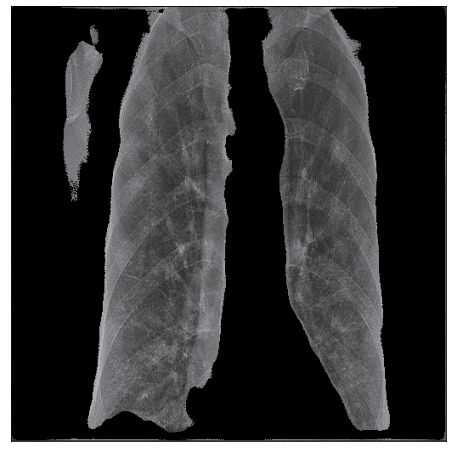

In [ ]:
img_data = cv2.imread(img_path)
img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
img_data = cv2.resize(img_data,(512,512))
print(img_data.shape)

img=preprocess(img_path)
pred = model.predict(img)
mask=get_img(pred)

res = apply_mask_mod(img_data,mask = mask)

plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(res,cmap='gray')
plt.savefig("/content/applied_mask.png",dpi=96)